In [95]:
# First we will import the necessary Library 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import SimpleRNN, Flatten


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [96]:
maindf = pd.read_csv("../data/BTC-USD.csv")

In [97]:
print('Total number of days present in the dataset: ',maindf.shape[0])
print('Total number of fields present in the dataset: ',maindf.shape[1])

Total number of days present in the dataset:  366
Total number of fields present in the dataset:  7


In [98]:
maindf.shape

(366, 7)

In [99]:
maindf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-06-27,21028.238281,21478.089844,20620.199219,20735.478516,20735.478516,2.096570e+10
1,2022-06-28,20731.544922,21164.423828,20228.812500,20280.634766,20280.634766,2.138154e+10
2,2022-06-29,20281.169922,20364.156250,19937.791016,20104.023438,20104.023438,2.355274e+10
3,2022-06-30,20108.312500,20141.160156,18729.656250,19784.726563,19784.726563,2.626724e+10
4,2022-07-01,19820.470703,20632.671875,19073.708984,19269.367188,19269.367188,3.076755e+10


In [100]:
maindf.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
361,2023-06-23,29896.382813,31389.539063,29845.214844,30695.468750,30695.468750,2.411557e+10
362,2023-06-24,30708.738281,30804.148438,30290.146484,30548.695313,30548.695313,1.214782e+10
363,2023-06-25,30545.150391,31041.271484,30327.943359,30480.261719,30480.261719,1.270346e+10
364,2023-06-26,NaN,NaN,NaN,NaN,NaN,NaN
365,2023-06-27,30266.720703,30491.828125,30245.511719,30355.761719,30355.761719,1.455609e+10


In [101]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       366 non-null    object 
 1   Open       365 non-null    float64
 2   High       365 non-null    float64
 3   Low        365 non-null    float64
 4   Close      365 non-null    float64
 5   Adj Close  365 non-null    float64
 6   Volume     365 non-null    float64
dtypes: float64(6), object(1)
memory usage: 20.1+ KB


In [102]:
maindf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,365.000000,365.000000,365.000000,365.000000,365.000000,3.650000e+02
mean,22403.478077,22809.412035,22032.297335,22430.576873,22430.576873,2.581784e+10
std,4055.217581,4158.346829,3994.587276,4079.167443,4079.167443,1.290374e+10
min,15782.300781,16253.047852,15599.046875,15787.284180,15787.284180,7.044911e+09
25%,19328.140625,19635.802734,19029.757813,19329.833984,19329.833984,1.643742e+10
50%,21787.000000,22314.941406,21445.957031,21808.101563,21808.101563,2.402180e+10
75%,26335.441406,26770.289063,25878.429688,26345.998047,26345.998047,3.142156e+10
max,30708.738281,31389.539063,30327.943359,30695.468750,30695.468750,1.189925e+11


In [103]:
print('Null Values:',maindf.isnull().values.sum())

Null Values: 6


In [104]:
print('NA values:',maindf.isnull().values.any())

NA values: True


In [105]:
# If dataset had null values we can use this code to drop all the null values present in the dataset
maindf=maindf.dropna()
print('Null Values:',maindf.isnull().values.sum())
print('NA values:',maindf.isnull().values.any())

Null Values: 0
NA values: False


In [106]:
maindf.shape

(365, 7)

In [107]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

In [108]:
closedf = maindf[['Date','Close']]
close_stock = closedf.copy()
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (365, 2)


In [109]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Bitcoin close price 2022-2023', plot_bgcolor='white', 
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [110]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)


(365, 1)


In [111]:
# we keep the training set as 70% and 30% testing set

training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (255, 1)
test_data:  (110, 1)


In [112]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [113]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (239, 15)
y_train:  (239,)
X_test:  (94, 15)
y_test (94,)


In [114]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (239, 15, 1)
X_test:  (94, 15, 1)


In [116]:
model=Sequential()

#first RNN layer
model.add(SimpleRNN(128,return_sequences=True, input_shape=(X_train.shape[1],1),activation="relu"))
model.add(Dropout(0.25))

model.add(SimpleRNN(256,return_sequences=True,activation="relu"))
model.add(Dropout(0.25))

model.add(SimpleRNN(512,return_sequences=True,activation="relu"))
model.add(Dropout(0.25))

model.add(SimpleRNN(256,return_sequences=True,activation="relu"))
model.add(Dropout(0.25))

model.add(SimpleRNN(128,return_sequences=True,activation="relu"))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_16 (SimpleRNN)   (None, 15, 128)           16640     
                                                                 
 dropout_12 (Dropout)        (None, 15, 128)           0         
                                                                 
 simple_rnn_17 (SimpleRNN)   (None, 15, 256)           98560     
                                                                 
 dropout_13 (Dropout)        (None, 15, 256)           0         
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 15, 512)           393728    
                                                                 
 dropout_14 (Dropout)        (None, 15, 512)           0         
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 15, 256)          

In [117]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
8/8 [==============================] - 5s 140ms/step - loss: 0.0765 - val_loss: 0.1210
Epoch 2/100
8/8 [==============================] - 0s 57ms/step - loss: 0.0185 - val_loss: 0.1268
Epoch 3/100
8/8 [==============================] - 0s 56ms/step - loss: 0.0141 - val_loss: 0.0785
Epoch 4/100
8/8 [==============================] - 0s 62ms/step - loss: 0.0111 - val_loss: 0.0072
Epoch 5/100
8/8 [==============================] - 0s 64ms/step - loss: 0.0108 - val_loss: 0.0396
Epoch 6/100
8/8 [==============================] - 0s 56ms/step - loss: 0.0098 - val_loss: 0.0556
Epoch 7/100
8/8 [==============================] - 0s 59ms/step - loss: 0.0095 - val_loss: 0.0216
Epoch 8/100
8/8 [==============================] - 0s 58ms/step - loss: 0.0073 - val_loss: 0.0122
Epoch 9/100
8/8 [==============================] - 0s 60ms/step - loss: 0.0078 - val_loss: 0.0254
Epoch 10/100
8/8 [==============================] - 0s 52ms/step - loss: 0.0066 - val_loss: 0.0238
Epoch 11/100
8/8 [

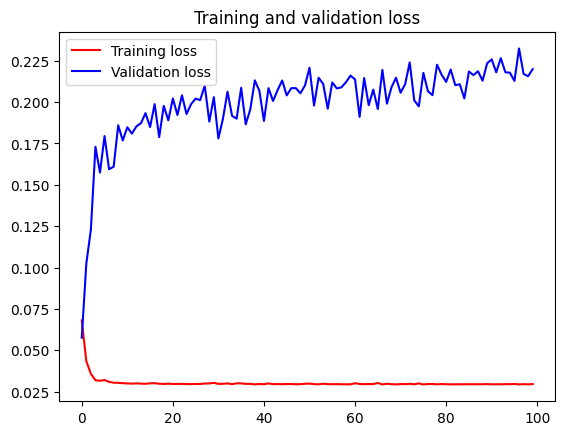

<Figure size 640x480 with 0 Axes>

In [92]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [118]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape


3/3 [==============================] - 0s 18ms/step


((239, 1), (94, 1))

In [119]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [120]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  520.7428778097392
Train data MSE:  271173.14478956896
Train data MAE:  370.18813337683054
-------------------------------------------------------------------------------------
Test data RMSE:  2412.333789472452
Test data MSE:  5819354.31183052
Test data MAE:  2292.6833859880326


In [121]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9586774924011043
Test data explained variance regression score: 0.6829228960414009


In [122]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (365, 1)
Test predicted data:  (365, 1)


In [29]:
model.save("../models/btcusd_rnn_model.h5")